In [1]:
### notebook from kyle
%matplotlib inline
# Import statements
import tensorflow as tf
import numpy as np
import random
from tensorflow.math import reduce_sum, square, maximum

layers = tf.keras.layers
optimizers = tf.keras.optimizers

In [2]:
#%%
# # Dataset Prep
#%%
# ### Create Pairs
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)

In [3]:
#%%
(x_train, y_train), (x_test, y_test) = mnist = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

input_shape = x_train.shape[1:]

num_classes = 10

digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
#%%
print(len(tr_pairs))

108400


In [4]:
#%%
# # Model Creation
# ### Custom layer definitions
def euclidean_distance(tensors):
    encoded_l, encoded_r = tensors
    sum_square = tf.math.reduce_sum(tf.math.square(encoded_l - encoded_r), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [5]:
#%%
# Define siamese model
def genSiameseNet():

    def eucl_dist_output_shape(shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    input = tf.keras.Input(shape=input_shape)
    x = layers.Flatten()(input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    # x = layers.Conv2D(64, 10, activation='relu', name='conv1')(input)
    # x = layers.MaxPool2D()(x)
    # x = layers.Conv2D(128, 7, activation='relu', name='conv2')(x)
    # x = layers.MaxPool2D()(x)
    # x = layers.Conv2D(128, 4, activation='relu', name='conv3')(x)
    # x = layers.MaxPool2D()(x)
    # x = layers.Conv2D(256, 4, activation='relu', name='conv4')(x)
    # x = layers.Flatten()(x)
    # x = layers.Dense(4096, activation='sigmoid', name='fc1')(x)
    base_model = tf.keras.Model(input, x, name='base_model')

    input_l = tf.keras.Input(shape=input_shape)
    input_r = tf.keras.Input(shape=input_shape)

    encoding_l = base_model(input_l)
    encoding_r = base_model(input_r)

    # distance = layers.Lambda(euclidean_distance)([encoding_l, encoding_r])
    distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([encoding_l, encoding_r])
    prediction = layers.Dense(1, activation='sigmoid')(distance)

    siamese_net = tf.keras.Model(inputs=[input_l, input_r], outputs=prediction)

    base_model.summary()
    siamese_net.summary()
    return siamese_net

In [6]:
#%%
# ### Create Model
siamese_net = genSiameseNet()
#%%

W0911 22:49:32.619364 140145140549376 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

In [7]:
# ### Create optimizer for training
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [8]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [9]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return tf.math.reduce_mean(tf.cast(tf.math.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), y_true.dtype))

In [10]:
optimizer = optimizers.Adam(lr = 0.00006)
# optimizer = optimizers.RMSprop()
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])

In [11]:
#%%
siamese_net.fit(
    [tr_pairs[:, 0], tr_pairs[:, 1]],
    tr_y,
    batch_size=128,
    epochs=50,
    validation_data=(
        [te_pairs[:, 0], te_pairs[:, 1]],
        te_y
    )
)

W0911 22:49:40.682204 140145140549376 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 108400 samples, validate on 17820 samples
Epoch 1/50
108400/108400 [==============================] - 2s 22us/sample - loss: 0.2615 - accuracy: 0.4986 - val_loss: 0.2502 - val_accuracy: 0.4889
Epoch 2/50
108400/108400 [==============================] - 2s 18us/sample - loss: 0.2502 - accuracy: 0.4968 - val_loss: 0.2501 - val_accuracy: 0.5015
Epoch 3/50
108400/108400 [==============================] - 2s 19us/sample - loss: 0.2501 - accuracy: 0.4982 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 4/50
108400/108400 [==============================] - 2s 19us/sample - loss: 0.2501 - accuracy: 0.4997 - val_loss: 0.2500 - val_accuracy: 0.5017
Epoch 5/50
108400/108400 [==============================] - 2s 20us/sample - loss: 0.2500 - accuracy: 0.5005 - val_loss: 0.2500 - val_accuracy: 0.4992
Epoch 6/50
108400/108400 [==============================] - 2s 19us/sample - loss: 0.2500 - accuracy: 0.5011 - val_loss: 0.2500 - val_accuracy: 0.4996
Epoch 7/50
108400/108400 [=================

In [12]:
#%%
y_pred = siamese_net.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = siamese_net.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 59.40%
* Accuracy on test set: 48.35%


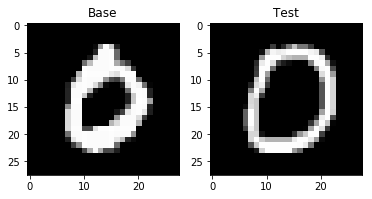

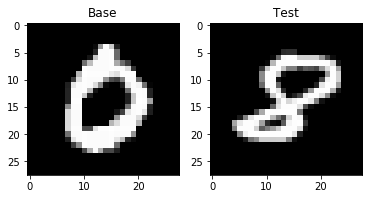

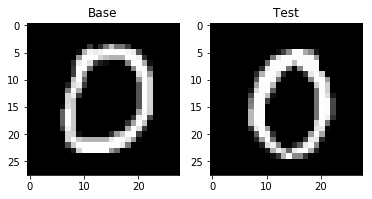

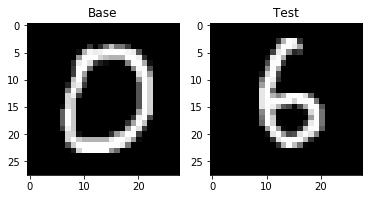

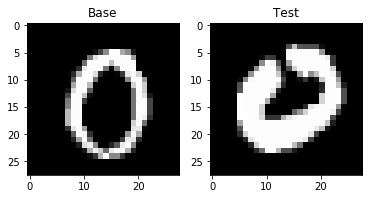

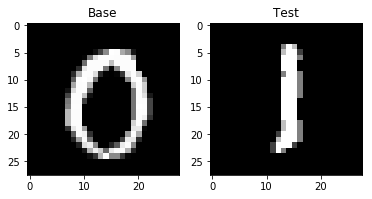

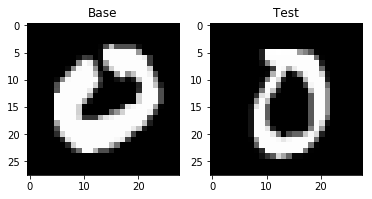

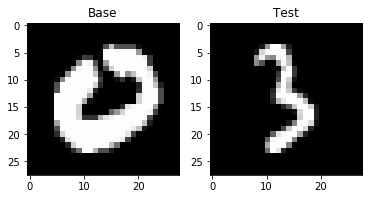

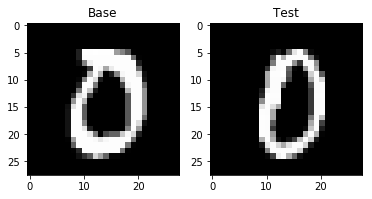

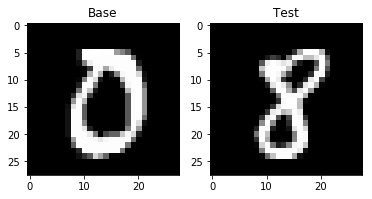

In [14]:
#%%
import matplotlib.pyplot as plt

# plt.title("MNist Character Test")
for i, p in enumerate(te_pairs[:10]):
    fig = plt.figure()
    sp = fig.add_subplot(1,2,1)
    sp.set_title("Base")
    plt.imshow(p[0], cmap='gray')

    sp = fig.add_subplot(1,2,2)
    sp.set_title("Test")
    plt.imshow(p[1], cmap='gray')
    sp.text(0,2,"{}: {}".format(y_pred[i] < 0.3, y_pred[i]))

    plt.show()
